# Final assignment of “Management and Analysis of Physics Datasets”

#### Giacomo Barzon (1207274) - Delfina Iriarte (1231682) - Karan Kabbur Hanumanthappa Manjunatha (1236383)

In [1]:
#importing libraries
import nltk 
from dask.distributed import Client, progress, LocalCluster
import dask.bag as db
import json

import pandas as pd
import  matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter

import time
from collections import Counter
import dask

# Part 1

# Introduction

In this section we will perform a $\textit{Word Counter distributed algorithm}$ over a dataset consisting of json files of 1000 research papers on COVID-19.

In order to analyse the data, we begin by sanitizing it to obtain the papers in json in a single line format since the papers are structured.  


In [ ]:
#!/bin/bash
mkdir -p data/papers_in_json_singleline
cd data/papers_in_json
for filename in *.json; do
	echo $filename
	jq -c . $filename > ../papers_in_json_singleline/$filename
done
cd -


#### Word counter distributed algorithm

We begin by counting the occurence of all the words inside a list of documents. This is done by two ways:

 - $\textit{Map phase}$: The frequency of words for each paper is counted.

 - $\textit{Reduce phase}$ : The frequency of words for the whole 1000 papers taken together is counted.
 
 To apply the counter, we need to remove the stop-words. This is done by making use of the following dictionary.

In [1]:
# Run only one time in order to download stopwords dictionary
# We import Natural languguage toolkit to remove stop words like a, an, the, i, aren't....and so on.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/karan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Caching the stopwords object. Constructing this each time you call the function can be a bottleneck.
# courtesy: https://stackoverflow.com/questions/19560498/faster-way-to-remove-stop-words-in-python
cachedStopWords = stopwords.words("english")

# removing few more words from body-text by adding them to a list of stop words
for word in ['et','al','also','may','fig','figure']:
    cachedStopWords.append(word)

pattern = re.compile(r'\b(' + r'|'.join(cachedStopWords) + r')\b\s*')

In [4]:
cachedStopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

#### Create cluster

In [3]:
#client = Client('192.168.1.54:8786')
#client = Client()
client = Client('0.tcp.ngrok.io:19016')
client

Client Scheduler: tcp://127.0.0.1:39837 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.25 GB


In [4]:
# create dask bag
# use dask bag to read json files. 
b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=50)
b

dask.bag<repartition, npartitions=50>

In [5]:
# Count the number of occurrences of each word in each document
def wordCount(text):
    text = re.sub('\W+',' ', text) # remove special characters (.,!)
    text = re.sub(r'\b[0-9]+\b\s*', ' ', text) # remove words containing only numbers
    wordlist = text.lower().split() # split text in strings
    wordfreq = [wordlist.count(p) for p in wordlist] # count word's occurrence
    
    return [{'word, count': list(zip(wordlist, wordfreq))}]


# Concatenating the strings contained into the body-text fields of the JSONs
def concatText_list(body_text):
    # Concatenating the strings contained into the body-text fields of the JSONs
    concat = [item['text'] for item in body_text]
    text= "".join(concat)
    
    text = re.sub('\W+',' ', text) # remove special characters (.,!)
    text = re.sub(r'\b[0-9]+\b\s*', ' ', text) # remove words containing only numbers
    text = text.lower() # set to lowercase
    # sub Replaces one or many matches with a string
    text = pattern.sub('', text) # remove stop-words
    wordlist = text.split() # split text in strings
    
    return wordlist

### Implementation of Regular Expression(RegEx)

We use the RegEX module which consider the following:
 
 - \ Signals a special sequence (can also be used to escape special characters)


 - \W 	Returns a match where the string DOES NOT contain any word characters


 - $[+]$ In sets, +, *, ., |, (), $\$$,{} has no special meaning, so [+] means: return a match for any + character in the string
 
 
 - \b 	Returns a match where the specified characters are at the beginning or at the end of a word (the "r" in the beginning is making sure that the string is being treated as a "raw string")


 - [0-9] Returns a match for any digit between 0 and 9


 - \s Returns a match where the string contains a white space character

A regular expression followed by an asterisk ( * ) matches zero or more occurrences of the regular expression. If there is any choice, the first matching string in a line is used. A regular expression followed by a plus sign ( + ) matches one or more occurrences of the one-character regular expression.

(courtesy: https://www.w3schools.com/python/python_regex.asp)

# MAP PHASE

In [6]:
# Map phase
init_bag = b.map(lambda record: record['body_text']).map(concatText_list) 
map_phase = init_bag.map(Counter)

In [7]:
%%time
results = map_phase.compute()

CPU times: user 3.29 s, sys: 248 ms, total: 3.54 s
Wall time: 12.9 s


In [12]:
results[2]

Counter({'since': 2,
         'first': 1,
         'human': 10,
         'case': 2,
         'middle': 2,
         'east': 1,
         'respiratory': 2,
         'syndrome': 2,
         'coronavirus': 2,
         'mers': 8,
         'cov': 8,
         'infection': 7,
         'detected': 1,
         'substantial': 1,
         'evidence': 1,
         'base': 1,
         'built': 1,
         'showing': 1,
         'dromedary': 6,
         'camels': 3,
         'zoonotic': 1,
         'source': 1,
         'virus': 2,
         'circulates': 1,
         'extensively': 1,
         'populations': 2,
         'causing': 1,
         'impactful': 1,
         'disease': 1,
         'however': 2,
         'associated': 1,
         'measured': 2,
         'fatality': 1,
         'ratio': 1,
         'around': 1,
         'following': 1,
         'spillover': 2,
         'events': 2,
         'transmission': 3,
         'relatively': 1,
         'inefficient': 1,
         'limited': 1,
         'cl

In [8]:
# function to sort the word and its frequency from higher to lower for each paper.
def plot_bar(results):
    def data_sort(results):
        total = list(results.keys()), list(results.values()) 
        data = pd.DataFrame(total)
        data = data.T
        data.columns = ['Word', 'Count']
        data = data.sort_values(['Count'], ascending=False)
        return data
    
    data = data_sort(results)
    # just get unique words
    names = data['Word'].unique()
    
    words = []
    counts = []
    
    # get only top 10 words for each paper
    for name in names[0:10]:
        data = data_sort(results)
        data = data[data['Word'] == name]
        val = data['Count'].sum()
        words.append(name)
        counts.append(val)
        
    return(words, counts)

In [9]:
words, counts = plot_bar(results[0])
words_1, counts_1 = plot_bar(results[1])
words_2, counts_2 = plot_bar(results[2])
words_3, counts_3 = plot_bar(results[3])
words_4, counts_4 = plot_bar(results[4])

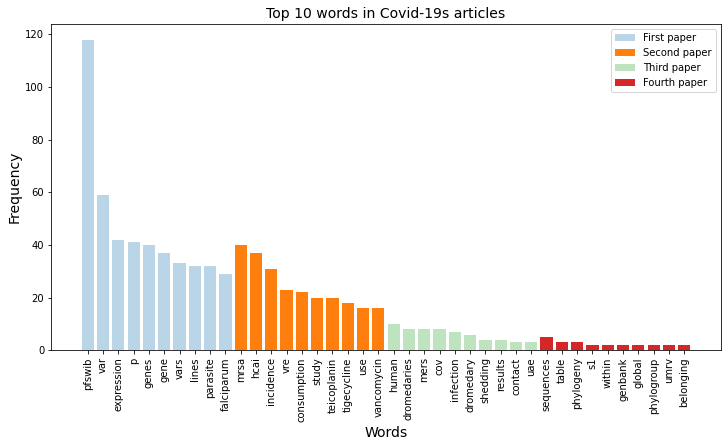

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(words, counts, label = 'First paper',alpha = 0.3)
plt.bar(words_1, counts_1, label = 'Second paper')
plt.bar(words_2, counts_2, label = 'Third paper',alpha = 0.3)
plt.bar(words_3, counts_3,  label = 'Fourth paper')

plt.title('Top 10 words in Covid-19s articles',size=14)
plt.xlabel('Words',size=14)
plt.ylabel('Frequency',size=14)
plt.xticks(rotation=90)
plt.legend()
plt.show()

# REDUCE PHASE

In [11]:
## Reduce phase
reduce_phase = init_bag.flatten().frequencies(sort=True)

In [12]:
%%time
results = reduce_phase.compute()

CPU times: user 3.07 s, sys: 186 ms, total: 3.25 s
Wall time: 11.4 s


In [18]:
results

[('patients', 12458),
 ('cells', 11604),
 ('virus', 9211),
 ('infection', 8001),
 ('study', 7632),
 ('c', 7399),
 ('using', 7394),
 ('used', 7091),
 ('cell', 6550),
 ('data', 6540),
 ('viral', 6346),
 ('disease', 6270),
 ('p', 6159),
 ('e', 6095),
 ('one', 6069),
 ('two', 5995),
 ('protein', 5771),
 ('time', 5595),
 ('n', 5451),
 ('results', 5264),
 ('however', 5220),
 ('high', 4759),
 ('studies', 4700),
 ('different', 4688),
 ('clinical', 4658),
 ('human', 4567),
 ('cov', 4304),
 ('based', 4296),
 ('g', 4268),
 ('b', 4246),
 ('analysis', 4167),
 ('treatment', 4148),
 ('covid', 4130),
 ('cases', 4129),
 ('group', 4101),
 ('sars', 4085),
 ('number', 4083),
 ('could', 4067),
 ('use', 4013),
 ('rna', 4010),
 ('well', 3944),
 ('associated', 3891),
 ('specific', 3868),
 ('first', 3862),
 ('h', 3840),
 ('viruses', 3837),
 ('control', 3780),
 ('respiratory', 3763),
 ('infected', 3762),
 ('expression', 3756),
 ('found', 3706),
 ('model', 3705),
 ('health', 3610),
 ('including', 3446),
 ('repor

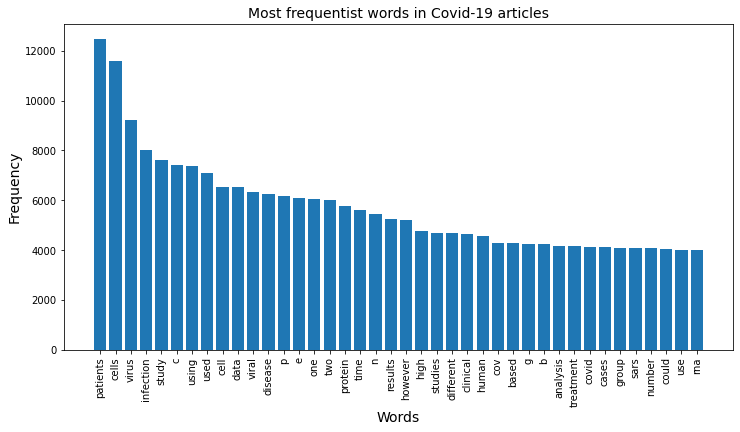

In [13]:
#plotting the top 40 words. 
words = []
counts = []
for i in range(40):
    words.append(results[i][0])
    counts.append(results[i][1])


plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.title('Most frequentist words in Covid-19 articles',size=14)
plt.xlabel('Words',size=14)
plt.ylabel('Frequency',size=14)
plt.xticks(rotation=90)
plt.show()

# Effect of number of partition

We increase the number of partitions from 1 to 500 to check which partitions takes less computation time and how the partitions affects the performance.

In [13]:
partition_time = []
partitions = [1,2,3,4,5,10,20,50,60,70,80,90,100,200,300,400,500]
for npart in partitions:
    print('n_partitions:',npart)
    start_time = time.time()
    b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=npart)
    init = b.map(lambda record: record['body_text']).map(concatText_list)
    map_phase = init.map(Counter)
    reduce_phase = init.flatten().frequencies(sort=True)
    
    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)
    
    end_time = time.time()
    print('Time taken:',end_time-start_time,'\n')
    partition_time.append(end_time-start_time)

n_partitions: 1
Time taken: 27.29949951171875 

n_partitions: 2
Time taken: 24.40164566040039 

n_partitions: 3
Time taken: 20.675320386886597 

n_partitions: 4
Time taken: 22.377570390701294 

n_partitions: 5
Time taken: 22.56488823890686 

n_partitions: 10
Time taken: 20.464492559432983 

n_partitions: 20
Time taken: 20.104154348373413 

n_partitions: 50
Time taken: 20.21301555633545 

n_partitions: 60
Time taken: 19.919442892074585 

n_partitions: 70
Time taken: 19.95513939857483 

n_partitions: 80
Time taken: 19.713534355163574 

n_partitions: 90
Time taken: 19.9750816822052 

n_partitions: 100
Time taken: 19.537673234939575 

n_partitions: 200
Time taken: 20.06997537612915 

n_partitions: 300
Time taken: 21.22664213180542 

n_partitions: 400
Time taken: 21.653436183929443 

n_partitions: 500
Time taken: 23.43238353729248 



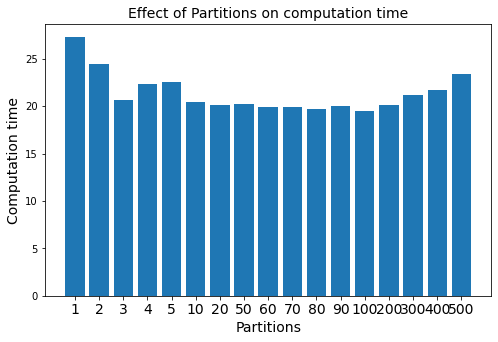

In [14]:
# Bar plot of Time vs Number of partitions
plt.figure(figsize=(8, 5))
plt.bar(range(len(partitions)),partition_time)
plt.title('Effect of Partitions on computation time',size=14)
plt.xlabel('Partitions',size=14)
plt.ylabel('Computation time',size=14)
plt.xticks(range(len(partitions)),partitions,size=14)
plt.show()

#### Conclusion:
We see from the above plot that having partitions from 5 to 70 has lesser amount of computation time as compared to the two extremes on left side as well as right side. We notice the partitions=50-80 performs better. 

There is a cost to having too many or having too few.

Partitions should fit comfortably in memory (smaller than a gigabyte) but also not be too many. Every operation on every partition takes the central scheduler a few hundred microseconds to process. If you have a few thousand tasks this is barely noticeable, but it is nice to reduce the number if possible.

In [30]:
client.close()

## Effect of Number of workers

In [23]:
Nworkers = list(range(1,11))
Nworkers

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [24]:
# We consider number of partition=50 (optimal) from the previous conclusion.
worker_time=[]

for workers in Nworkers:
    # Create a local cluster with as many workers as cores 
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster)

    start_time = time.time()
    b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=50)
    init = b.map(lambda record: record['body_text']).map(concatText_list)
    map_phase = init.map(Counter)
    reduce_phase = init.flatten().frequencies(sort=True)

    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)

    end_time = time.time()
    worker_time.append(end_time-start_time)
    client.close() # close client
    myCluster.close() # close cluster
    

print(worker_time)

[31.595762491226196, 23.931443452835083, 20.536068201065063, 19.741570949554443, 20.887548208236694, 20.457263946533203, 21.949565172195435, 21.667745113372803, 21.60739254951477, 21.330113410949707]


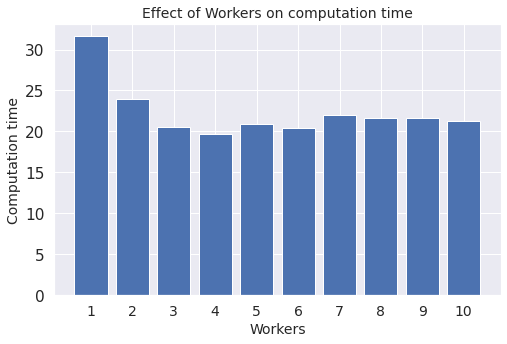

In [25]:
# Bar plot of Time vs Number of workers
plt.figure(figsize=(8, 5))
plt.bar(Nworkers, worker_time)
plt.title('Effect of Workers on computation time',size=14)
plt.xlabel('Workers',size=14)
plt.ylabel('Computation time',size=14)
plt.xticks(Nworkers,size=14)
plt.show()

We see that with the increase in the number of workers, the computation time decreases. Since the task is more, workers 1,2 or even 3 takes more computation time. **4 workers + thread=1 each, with partition=50 is found to be optimal.** But again with the increase in the workers from 4 onwards, the computation time increases.  

In general when we have to deal with a cluster we have to think about the overhead. We can image the overhead like the the computational time necessary to process the data(which is json files here). Typically in a cluster there two kind of overhead:

    Scheduler overhead - In serializing the objects that must be sent to workers
    Connection overhead - The speed of the network connection between the cluster nodes

In the first case, the scheduler adds about one millisecond of overhead per task of Future object. Despite this may sound fast or inconsequential, it's quite slow if you run a large number of tasks. Under this perspective, a larger number of the task means a larger amount of time to create the Future objects of the tasks. In the light of above, if your functions run faster than 100ms or so then you might not see any speedup from using distributed computing, but even worse, probably you might see that the performances get worse.

In the second case things are different. The connection overhead may depends from several factors including the stability of the network, the type (wired or WiFi or optic fibe), and bandwith of the network.

This is what is happening in the here.

In [13]:
client.close()

#### Grid Search

We will now perform an analysis of the effects of the parition and worker by creating a Grid Search.

In [16]:
def time_grid(workers, partitions):
    
    # Create a local cluster with as many workers as cores 
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster)
    
    start_time = time.time()
    b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=partitions)
    init = b.map(lambda record: record['body_text']).map(concatText_list)
    map_phase = init.map(Counter)
    reduce_phase = init.flatten().frequencies(sort=True)

    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)
    
    end_time = time.time()
    
    client.close() 
    myCluster.close()
    
    return (end_time-start_time)

In [19]:
import numpy as np
import time

# Number of workers
workers = [1,2,4,6,8]
# Partitions factor
partitions = [1, 5, 20, 50,100] 

times = np.zeros((len(workers),len(partitions))) 

# create a computation time matrix for all combinations of workers and partitions
for w in range(len(workers)):
    for p in range(len(partitions)):
        times[w][p] = time_grid(workers[w],partitions[p])

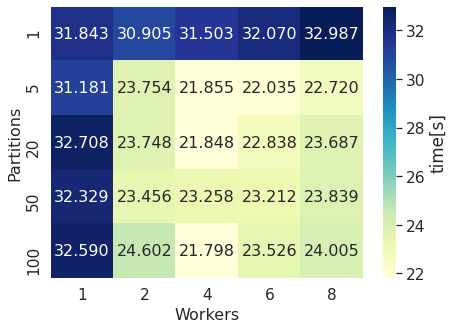

In [20]:
import seaborn as sns
df_cm = pd.DataFrame(times.T, partitions, workers)


plt.figure(figsize=(7,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
           cbar_kws={'label':'time[s]'},cmap="YlGnBu")
plt.xlabel('Workers',fontsize=16)
plt.ylabel('Partitions',fontsize=16)
plt.show()

It can be seen that the optimal time is observed for 4 workers and 100 partitions.
On the other hand, we observe that with small number of workers as well as  small number of partition the computational time increases.
